In [141]:
# Using Facebook's Prophet package to do some time series analysis on FBI gen violence data
# packages
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from statistics import stdev, mean

In [81]:
df = pd.read_csv("data/database_homicide1980-2014_FBI.csv", low_memory=False)
df.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [82]:
monthDict = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
            'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December': 12}
df['Month'] = df.Month.map(monthDict).map(int).map(lambda x: str(x) if x > 9 else "0" + str(x))
df['Year'] = df.Year.map(str)
df['DS'] = df['Year'] + "-" + df['Month']

In [149]:
crimes_month = df.groupby(['DS'])['Incident'].count()
crimes_month = pd.DataFrame(crimes_month)
crimes_month = crimes_month.reset_index()
crimes_month = crimes_month.rename({'DS':'ds', 'Incident':'y'}, axis = 'columns')
crimes_month.head()

,ds,y
0,1980-01,1825
1,1980-02,1730
2,1980-03,1743
3,1980-04,1760
4,1980-05,1863


In [144]:
#std = stdev(crimes_month.y)
#avg = mean(crimes_month.y)
#crimes_month.y = (crimes_month.y - avg)/std

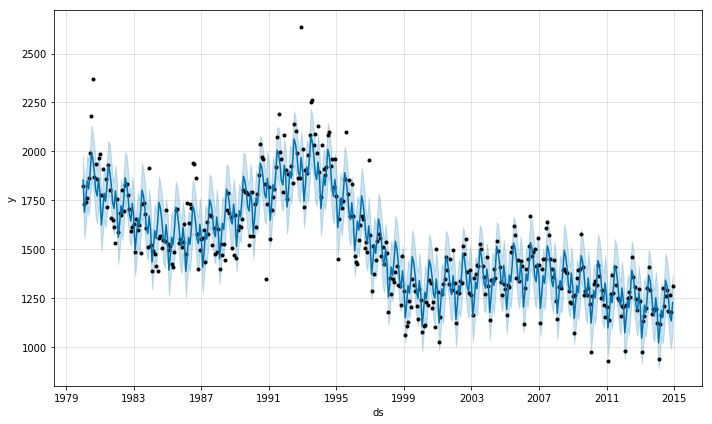

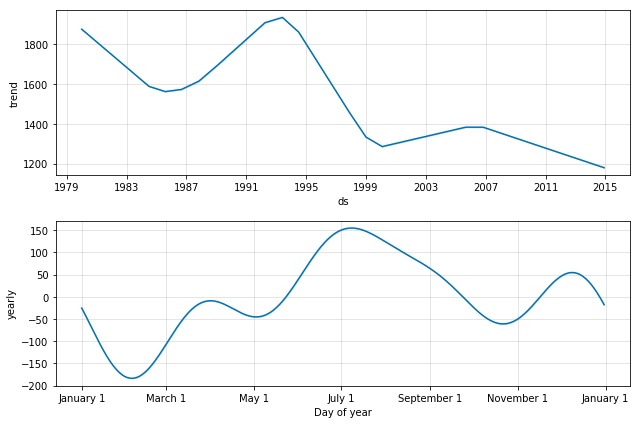

In [150]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=4,
               seasonality_mode='additive').fit(crimes_month)
future = model.make_future_dataframe(periods = 0, freq = 'M')
fcst = model.predict(future)
fig1 = model.plot(fcst)
fig2 = model.plot_components(fcst)

In [157]:
df_cv = cross_validation(model, initial='3650 days', period='360 days', horizon = '365 days')
df_p = performance_metrics(df_cv, metrics=['mse', 'rmse', 'mae', 'mape', 'coverage'])
df_p.aggregate('mean')

INFO:fbprophet:Making 25 forecasts with cutoffs between 1990-04-06 00:00:00 and 2013-12-01 00:00:00


horizon     200 days 22:29:40.073800
mse                          30613.8
rmse                         172.723
mae                          134.276
mape                       0.0916354
coverage                    0.609874
dtype: object